* Author: HZQ
* Last modified: 2019/1/25

# Main Parts

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools 
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null 
!apt-get update -qq 2>&1 > /dev/null 
!apt-get -y install -qq google-drive-ocamlfuse fuse 
from google.colab import auth 
auth.authenticate_user() 
from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default() 
import getpass 
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL 
vcode = getpass.getpass() 
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p driver
!google-drive-ocamlfuse driver
import os
os.chdir("driver/Colab Notebooks/CategoryRecom_kaggle/")
!ls

In [0]:
!ls

data	  driver		LICENSE  ReadMe.md	   submit    utils
download  lgbm_importances.png	model	 requirements.txt  timeline


In [0]:
!pip install --upgrade pandas

## Import required packages

In [0]:
import gc, sys

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

In [0]:
%matplotlib inline

## prepared process


### read data offline

In [0]:
DATA_ROOT_PATH = "data/"

In [0]:
data_train_full_scaled = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_train_full_scaled.csv")
data_test_full_scaled = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/data_test_full_scaled.csv")

In [0]:
# data_train_full_scaled_selected = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_train_full_scaled_selected.csv")
# data_test_full_scaled_selected = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/data_test_full_scaled_selected.csv")
data_train_full_scaled_selected = data_train_full_scaled
data_test_full_scaled_selected = data_test_full_scaled

In [0]:
labels = pd.read_csv(DATA_ROOT_PATH + "data_raw/train/train.csv")["target"]
data_train_full_scaled_selected.drop(["target"], axis=1, inplace=True)

### read data online

## model training

### baseline model: (e.g Linear regression)

### used model

In [0]:
import logging


def get_logger():
    FORMAT = '[%(levelname)s]%(asctime)s:%(name)s:%(message)s'
    logging.basicConfig(format=FORMAT)
    logger = logging.getLogger('main')
    logger.setLevel(logging.DEBUG)
    return logger

logger = get_logger()

#### LGBM

In [0]:
param = {'num_leaves': 51,
         'min_data_in_leaf': 35, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.008,
         "boosting": "gbdt",
         "feature_fraction": 0.85,
         "bagging_freq": 1,
         "bagging_fraction": 0.82,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.11,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 2019}

In [0]:
logger.info('Process train')
train_columns = list(data_train_full_scaled_selected.columns)
data_train_full_scaled_selected['outliers'] = 0
data_train_full_scaled_selected.loc[labels < -30, 'outliers'] = 1
outls = data_train_full_scaled_selected['outliers'].value_counts()
print("Outliers: {}".format(outls))

[INFO]2019-01-25 04:34:34,790:main:Process train


Outliers: 0    199710
1      2207
Name: outliers, dtype: int64


In [0]:
folds = StratifiedKFold(n_splits=9, shuffle=True, random_state=2019)
oof = np.zeros(len(data_train_full_scaled_selected))
predictions = np.zeros(len(data_test_full_scaled_selected))
feature_importance_df = pd.DataFrame()

logger.info('Start running model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(data_train_full_scaled_selected,data_train_full_scaled_selected['outliers'].values)):
    strLog = "fold {}".format(fold_)
    print(strLog) 
    trn_data = lgb.Dataset(data_train_full_scaled_selected.iloc[trn_idx][train_columns], label=labels.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(data_train_full_scaled_selected.iloc[val_idx][train_columns], label=labels.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 150)
    oof[val_idx] = clf.predict(data_train_full_scaled_selected.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(data_test_full_scaled_selected[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    logger.info(strLog)
    
strRMSE = "".format(np.sqrt(mean_squared_error(oof, labels)))
print(strRMSE)

[INFO]2019-01-25 04:37:00,841:main:Start running model


fold 0
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.74937	valid_1's rmse: 3.80987
[400]	training's rmse: 3.71497	valid_1's rmse: 3.80592
Early stopping, best iteration is:
[389]	training's rmse: 3.7165	valid_1's rmse: 3.80574


[INFO]2019-01-25 04:37:16,688:main:fold 0


fold 1
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.75139	valid_1's rmse: 3.7921
[400]	training's rmse: 3.71716	valid_1's rmse: 3.78948
Early stopping, best iteration is:
[411]	training's rmse: 3.71568	valid_1's rmse: 3.78922


[INFO]2019-01-25 04:37:32,839:main:fold 1


fold 2
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.75265	valid_1's rmse: 3.78074
[400]	training's rmse: 3.71823	valid_1's rmse: 3.77528
[600]	training's rmse: 3.69512	valid_1's rmse: 3.77503
Early stopping, best iteration is:
[478]	training's rmse: 3.70845	valid_1's rmse: 3.7747


[INFO]2019-01-25 04:37:51,251:main:fold 2


fold 3
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.75362	valid_1's rmse: 3.7745
[400]	training's rmse: 3.71933	valid_1's rmse: 3.77254
Early stopping, best iteration is:
[288]	training's rmse: 3.73667	valid_1's rmse: 3.77162


[INFO]2019-01-25 04:38:03,889:main:fold 3


fold 4
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.75171	valid_1's rmse: 3.79372
[400]	training's rmse: 3.71737	valid_1's rmse: 3.79266
Early stopping, best iteration is:
[294]	training's rmse: 3.73344	valid_1's rmse: 3.79222


[INFO]2019-01-25 04:38:16,823:main:fold 4


fold 5
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.75098	valid_1's rmse: 3.79363
[400]	training's rmse: 3.71624	valid_1's rmse: 3.78937
[600]	training's rmse: 3.69229	valid_1's rmse: 3.78866
Early stopping, best iteration is:
[635]	training's rmse: 3.68891	valid_1's rmse: 3.78845


[INFO]2019-01-25 04:38:39,970:main:fold 5


fold 6
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.75182	valid_1's rmse: 3.78573
[400]	training's rmse: 3.71674	valid_1's rmse: 3.783
Early stopping, best iteration is:
[352]	training's rmse: 3.7238	valid_1's rmse: 3.78257


[INFO]2019-01-25 04:38:54,534:main:fold 6


fold 7
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.74975	valid_1's rmse: 3.80317
[400]	training's rmse: 3.71529	valid_1's rmse: 3.80193
[600]	training's rmse: 3.69248	valid_1's rmse: 3.80121
[800]	training's rmse: 3.67374	valid_1's rmse: 3.80105
Early stopping, best iteration is:
[687]	training's rmse: 3.68365	valid_1's rmse: 3.80056


[INFO]2019-01-25 04:39:19,420:main:fold 7


fold 8
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.75351	valid_1's rmse: 3.78122
[400]	training's rmse: 3.71935	valid_1's rmse: 3.77752
Early stopping, best iteration is:
[378]	training's rmse: 3.72251	valid_1's rmse: 3.77724


[INFO]2019-01-25 04:39:34,666:main:fold 8


In [0]:
len(data_test_full_scaled_selected)

201917

[INFO]2019-01-25 05:49:12,331:main:Feature importance plot
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


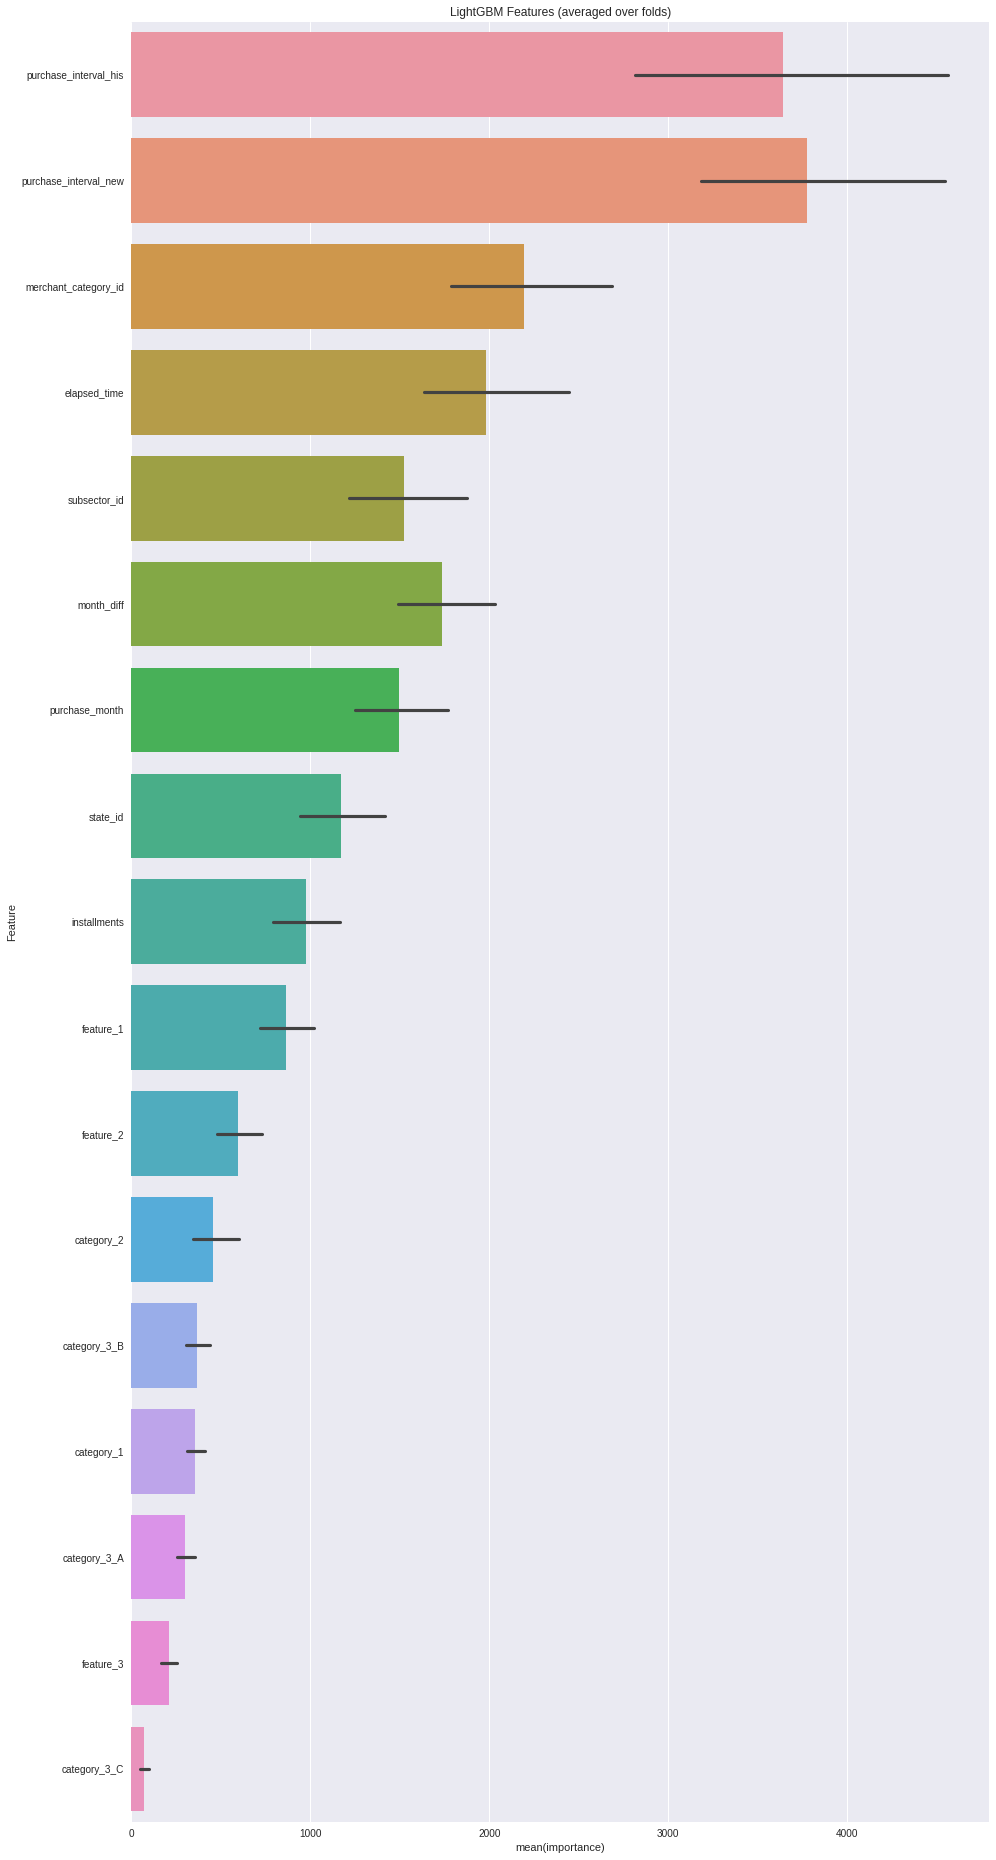

In [0]:
logger.info("Feature importance plot")
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [0]:
len(predictions)

201917

In [0]:
len(submit_sample)

123623

In [0]:
logger.info("Prepare submission")
submit_sample =  pd.read_csv("./submit/sample_submission.csv")
submit_sample["target"] = predictions
submit_sample.to_csv("./submit/submission_LGBM_hzq2.csv", index=False)

[INFO]2019-01-25 05:49:20,987:main:Prepare submission


## model validation


# Undertesting Parts

In [0]:
import gc, sys
gc.collect()
sys._clear_type_cache()